In [94]:
import torch
import torch.nn as nn
from typing import List

class Generator(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Feature extractor network."""
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Domain critic network."""
        super().__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [95]:
from typing import Optional
import numpy as np
from tqdm.notebook import trange
from torch.utils.data import DataLoader

class WDGRL():
    def __init__(self, input_dim: int=2, generator_hidden_dims: List[int]=[32, 16, 8, 4, 2], critic_hidden_dims: List[int]=[32, 16, 8, 4, 2],
                 gamma: float = 0.1, _lr_generator: float = 1e-2, _lr_critic: float = 1e-2, 
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):

        self.gamma = gamma
        self.device = device
        self.generator = Generator(input_dim, generator_hidden_dims).to(self.device)
        self.critic = Critic(generator_hidden_dims[-1], critic_hidden_dims).to(self.device)
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=_lr_generator)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=_lr_critic)
    
    # def compute_gradient_penalty(self, source_data: torch.Tensor, target_data: torch.Tensor) -> torch.Tensor:
    #     """Compute gradient penalty."""
    #     if source_data.size(0) > target_data.size(0):
    #         ms = source_data.size(0)
    #         mt = target_data.size(0)
    #         gradient_penalty = 0
    #         for _ in range(0, ms, mt):
    #             source_chunk = source_data[_:_+mt]
    #             target_chunk = target_data
    #             alpha = torch.rand(target_chunk.size(0), 1).to(self.device)
    #             interpolates = (alpha * source_chunk + ((1 - alpha) * target_chunk)).requires_grad_(True)
                
    #             # Domain critic outputs
    #             dc_output = self.critic(interpolates)
                
    #             # Compute gradients
    #             gradients = torch.autograd.grad(
    #                 outputs=dc_output,
    #                 inputs=interpolates,
    #                 grad_outputs=torch.ones_like(dc_output).to(self.device),
    #                 create_graph=True,
    #                 retain_graph=True,
    #                 only_inputs=True,
    #             )
    #             gradients = gradients[0]
    #             gradient_penalty += ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    #         if ms % mt != 0:
    #             source_chunk = source_data[ms-mt:]
    #             perm = torch.randperm(mt)
    #             idx = perm[:ms % mt]
    #             target_chunk = target_data[idx]
    #             alpha = torch.rand(target_chunk.size(0), 1).to(self.device)
    #             interpolates = (alpha * source_chunk + ((1 - alpha) * target_chunk)).requires_grad_(True)
                
    #             # Domain critic outputs
    #             dc_output = self.critic(interpolates)
                
    #             # Compute gradients
    #             gradients = torch.autograd.grad(
    #                 outputs=dc_output,
    #                 inputs=interpolates,
    #                 grad_outputs=torch.ones_like(dc_output).to(self.device),
    #                 create_graph=True,
    #                 retain_graph=True,
    #                 only_inputs=True,
    #             )
    #             gradients = gradients[0]
    #             gradient_penalty += ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    #         return gradient_penalty / ((ms // mt) + (ms % mt != 0)) 
        
    #     # For balanced batch
    #     alpha = torch.rand(source_data.size(0), 1).to(self.device)
    #     interpolates = (alpha * source_data + ((1 - alpha) * target_data)).requires_grad_(True)
        
    #     # Domain critic outputs
    #     dc_output = self.critic(interpolates)
        
    #     # Compute gradients
    #     gradients = torch.autograd.grad(
    #         outputs=dc_output,
    #         inputs=interpolates,
    #         grad_outputs=torch.ones_like(dc_output).to(self.device),
    #         create_graph=True,
    #         retain_graph=True,
    #         only_inputs=True,
    #     )[0]

    #     # Compute gradient penalty
    #     gradients = gradients.view(gradients.size(0), -1)
    #     return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    def compute_gradient_penalty(self, source_data: torch.Tensor, target_data: torch.Tensor) -> torch.Tensor:
        alpha = torch.rand(source_data.size(0), 1).to(self.device)
        differences = target_data - source_data 
        interpolates = source_data + (alpha * differences)
        interpolates = torch.stack([interpolates, source_data, target_data]).requires_grad_()

        preds = self.critic(interpolates)
        gradients = torch.autograd.grad(preds, interpolates,
                     grad_outputs=torch.ones_like(preds),
                     retain_graph=True, create_graph=True)[0]
        gradient_norm = gradients.norm(2, dim=1)
        gradient_penalty = ((gradient_norm - 1)**2).mean()
        return gradient_penalty


    def train(self, source_loader: DataLoader, target_loader: DataLoader, num_epochs: int = 100, dc_iter: int = 100) -> List[float]:
        self.generator.train()
        self.critic.train()
        losses = []
        source_critic_scores = []
        target_critic_scores = []
        for epoch in trange(num_epochs, desc='Epoch'):
            loss = 0
            total_loss = 0
            for (source_data, _), (target_data, _) in zip(source_loader, target_loader):
                source_data, target_data = source_data.to(self.device), target_data.to(self.device)

                # Train domain critic
                for _ in range(dc_iter):
                    self.critic_optimizer.zero_grad()
                    
                    with torch.no_grad():
                        source_features = self.generator(source_data).view(source_data.size(0), -1)
                        target_features = self.generator(target_data).view(target_data.size(0), -1)
                    
                    # Compute empirical Wasserstein distance
                    dc_source = self.critic(source_features)
                    dc_target = self.critic(target_features)
                    wasserstein_distance = (dc_source.mean() - dc_target.mean())

                    # Gradient penalty
                    gradient_penalty = self.compute_gradient_penalty(source_features, target_features)

                    # Domain critic loss
                    dc_loss = - wasserstein_distance + self.gamma * gradient_penalty
                    print(f'- iteration #{_} / {dc_iter} | source critic: {dc_source.mean().item()} | target critic: {dc_target.mean().item()} | wasserstein distance: {wasserstein_distance.item()} | gradient penalty: {gradient_penalty.item()}')
                    dc_loss.backward()
                    self.critic_optimizer.step()
                    with torch.no_grad():
                        total_loss += wasserstein_distance.item()
                print('-------------------------------')
                # Train feature extractor
                self.generator_optimizer.zero_grad()
                source_features = self.generator(source_data)
                target_features = self.generator(target_data)
                dc_source = self.critic(source_features)
                dc_target = self.critic(target_features)
                wasserstein_distance = (dc_source.mean() - dc_target.mean())
                wasserstein_distance.backward()
                self.generator_optimizer.step()
                with torch.no_grad():
                    loss += wasserstein_distance.item()
                
                    
            source_critic_scores.append(self.criticize(source_loader.dataset.tensors[0].to(self.device)))
            target_critic_scores.append(self.criticize(target_loader.dataset.tensors[0].to(self.device)))
            losses.append(loss/len(source_loader))
            print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {loss/len(source_loader)}')
            print('--------------------------------')
        return losses, source_critic_scores, target_critic_scores
    
    @torch.no_grad()
    def extract_feature(self, x: torch.Tensor) -> torch.Tensor:
        self.generator.eval()
        return self.generator(x)
    
    @torch.no_grad()
    def criticize(self, x: torch.Tensor) -> float:
        self.generator.eval()
        self.critic.eval()
        return self.critic(self.generator(x)).mean().item()

In [96]:
import numpy as np
# np.random.seed(42)
# torch.manual_seed(42)
def gen_data(mu: float, delta: List[int], n: int, d: int):
    mu = np.full((n, d), mu, dtype=np.float64)
    noise = np.random.normal(loc = 0, scale = 1, size=(n, d))
    X = mu + noise
    labels = np.zeros(n)
    # 5% of the data is abnormal.
    # Anomalies are generated by randomly adding deltas to the data.
    n_anomalies = int(n * 0.05)
    idx = np.random.choice(n, n_anomalies, replace=False)
    if 0 in delta: 
        delta.pop(delta.index(0))
    if len(delta) == 0:
        return X, labels
    split_points = sorted(np.random.choice(range(1, len(idx)), len(delta) - 1, replace=False))
    segments = np.split(idx, split_points)
    for i, segment in enumerate(segments):
        X[segment] = X[segment] + delta[i]
    labels[idx] = 1
    return X, labels

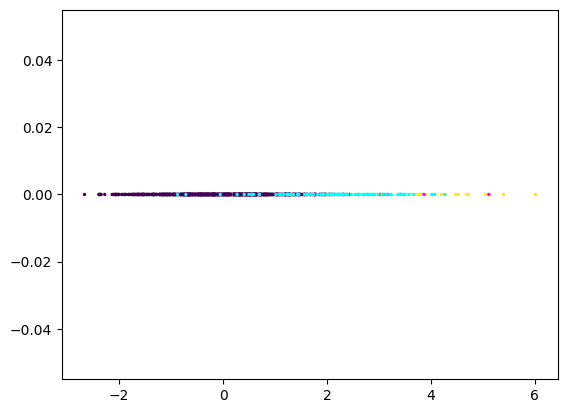

In [97]:
import matplotlib.pyplot as plt

"""Create synthetic dataset and dataloaders for domain adaptation."""
# Create datasets
ns, nt, d = 1000, 100, 32

xs, ys = gen_data(0, [0, 1, 2, 3, 4], ns, d)
xt, yt = gen_data(2, [0, 1, 2, 3, 4], nt, d)

plt.scatter(xs[:, 0], np.zeros_like(xs[:, 0]), c=ys, cmap='viridis', s=2)
plt.scatter(xt[:, 0], np.zeros_like(xt[:, 0]), c=yt, cmap='cool', s=2)
plt.show()

In [98]:
def common_divisors(N_A, N_B):
    gcd = np.gcd(N_A, N_B)  # Step 1: Compute GCD
    return [d for d in range(1, gcd + 1) if gcd % d == 0]

common_divisors(ns, nt)
cd = [d for d in reversed(common_divisors(ns, nt)) if nt//d >= 5]
cd = cd[0]
cd

20

In [99]:
# Convert to PyTorch tensors
xs = torch.FloatTensor(xs)
ys = torch.LongTensor(ys)
xt = torch.FloatTensor(xt)
yt = torch.LongTensor(yt)

from torch.utils.data import DataLoader, TensorDataset 
source_dataset = TensorDataset(xs, ys)
target_dataset = TensorDataset(xt, yt)
source_loader = DataLoader(source_dataset, batch_size=cd, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=cd, shuffle=True)

In [112]:
generator_hidden_dims = [500, 100, 20]
critic_hidden_dims = [100]
model = WDGRL(input_dim=d, generator_hidden_dims=generator_hidden_dims, critic_hidden_dims=critic_hidden_dims)
num_epochs = 5
losses, source_critic_scores, target_critic_scores = model.train(source_loader, target_loader, num_epochs=num_epochs, dc_iter=50)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

- iteration #0 / 50 | source critic: 0.05472953990101814 | target critic: 0.05739782378077507 | wasserstein distance: -0.0026682838797569275 | gradient penalty: 7.915710926055908
- iteration #1 / 50 | source critic: 0.05417805537581444 | target critic: 0.05605830252170563 | wasserstein distance: -0.0018802471458911896 | gradient penalty: 2.9819040298461914
- iteration #2 / 50 | source critic: 0.05313454940915108 | target critic: 0.05368310585618019 | wasserstein distance: -0.0005485564470291138 | gradient penalty: 0.9347186088562012
- iteration #3 / 50 | source critic: 0.052317455410957336 | target critic: 0.05184043198823929 | wasserstein distance: 0.0004770234227180481 | gradient penalty: 0.5549017786979675
- iteration #4 / 50 | source critic: 0.05208560451865196 | target critic: 0.05112653970718384 | wasserstein distance: 0.0009590648114681244 | gradient penalty: 0.583897054195404
- iteration #5 / 50 | source critic: 0.05237744003534317 | target critic: 0.05134805291891098 | wassers

In [113]:
xs_hat = model.extract_feature(xs.cuda())
xt_hat = model.extract_feature(xt.cuda())
xs_hat = xs_hat.cpu().numpy()
xt_hat = xt_hat.cpu().numpy()
print(xs_hat)
print(xt_hat)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.04681316 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.05895202 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.06239897 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


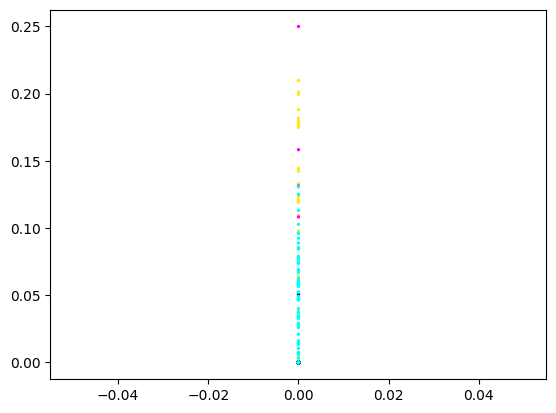

In [114]:
plt.scatter(xs_hat[:, 19], xs_hat[:, 17], c=ys, cmap='viridis', s=2)
plt.scatter(xt_hat[:, 19], xt_hat[:, 17], c=yt, cmap='cool', s=2)
plt.show()

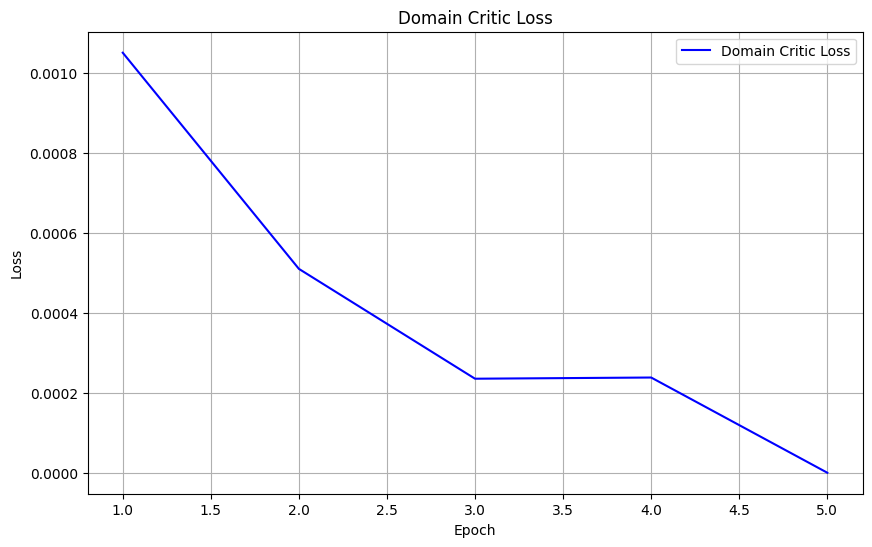

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), losses, 'b-', label='Domain Critic Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Domain Critic Loss')
plt.legend()
plt.grid(True)
plt.show()

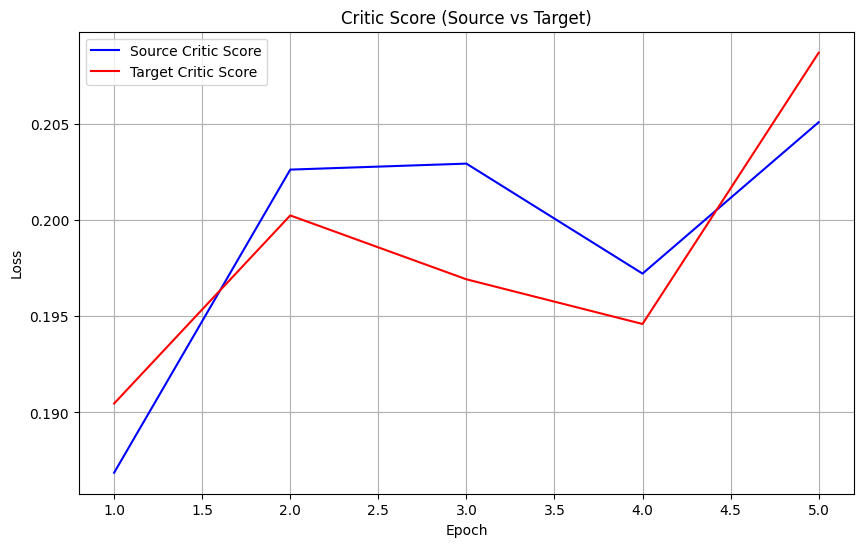

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), source_critic_scores, 'b-', label='Source Critic Score')
plt.plot(range(1, num_epochs+1), target_critic_scores, 'r-', label='Target Critic Score')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Critic Score (Source vs Target)')
plt.legend()
plt.grid(True)
plt.show()

In [117]:
# Define a dictionary with all the necessary components
checkpoint = {
    'generator_state_dict': model.generator.state_dict(),
    'critic_state_dict': model.critic.state_dict(),
    'device': model.device,
}
index = None

with open("wdgrl_models.txt", "r") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        words = line[:-1].split("/")
        if words[1] == str(generator_hidden_dims) and words[2] == str(critic_hidden_dims):
            index = i
            break
if index is None:
    with open("wdgrl_models.txt", "r") as f:
        index = len(f.readlines())
    with open("wdgrl_models.txt", "a") as f:
        f.write(f"{index}/{generator_hidden_dims}/{critic_hidden_dims}\n")
# Save the checkpoint
torch.save(checkpoint, f"wdgrl_{index}.pth")
print("Model saved successfully!")

Model saved successfully!


In [118]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim: int, encoder_hidden_dims: List[int], decoder_hidden_dims: List[int], lr: float = 0.001,
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        """Feature extractor network."""
        super().__init__()
        self.device = device
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in encoder_hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU(inplace=True))
            prev_dim = hidden_dim
        
        prev_dim = encoder_hidden_dims[-1]

        for hidden_dim in decoder_hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU(inplace=True))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, input_dim))
        
        self.net = nn.Sequential(*layers)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
    
    def forward(self, x):
        return self.net(x)

    def criterion(self, outputs, inputs):
        return torch.mean(torch.abs(outputs - inputs))
    
    @torch.no_grad()
    def reconstruction_loss(self, x):
        losses = []
        for i in range(x.shape[0]):
            losses.append(self.criterion(self.forward(x[i].unsqueeze(0)), x[i].unsqueeze(0)))
        return losses

    def train(self, data_loader: DataLoader, num_epochs: int = 100):
        losses = []
        for epoch in range(num_epochs):
            for batch in data_loader:
                inputs = batch[0]
                outputs = self.forward(inputs)
                loss = self.criterion(outputs, inputs)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {loss/len(data_loader)}')
            losses.append(loss.item() / len(data_loader))
        return losses

In [119]:
x_hat = np.concatenate((xs_hat, xt_hat), axis=0)
x_hat = torch.tensor(x_hat, dtype=torch.float32)
print(x_hat)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0624, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [125]:
input_dim = generator_hidden_dims[-1]
encoder_hidden_dims = [16, 8, 4, 2]
decoder_hidden_dims = [4, 8, 16, input_dim]
batch_size = 64
num_epochs = 29

model = AutoEncoder(input_dim, encoder_hidden_dims, decoder_hidden_dims)
dataset = torch.utils.data.TensorDataset(x_hat)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
losses = model.train(data_loader=data_loader, num_epochs = num_epochs)

Epoch 1/29 | Loss: 0.006602567154914141
Epoch 2/29 | Loss: 0.005336929578334093
Epoch 3/29 | Loss: 0.0036918306723237038
Epoch 4/29 | Loss: 0.001433660858310759
Epoch 5/29 | Loss: 0.0018575388239696622
Epoch 6/29 | Loss: 0.0013618575176224113
Epoch 7/29 | Loss: 0.0025770068168640137
Epoch 8/29 | Loss: 0.0014139635022729635
Epoch 9/29 | Loss: 0.0007224548025988042
Epoch 10/29 | Loss: 0.0006058727158233523
Epoch 11/29 | Loss: 0.0008159875869750977
Epoch 12/29 | Loss: 0.0015362468548119068
Epoch 13/29 | Loss: 0.0024097536224871874
Epoch 14/29 | Loss: 0.002310203155502677
Epoch 15/29 | Loss: 0.0013834531418979168
Epoch 16/29 | Loss: 0.0009468876523897052
Epoch 17/29 | Loss: 0.0009707522694952786
Epoch 18/29 | Loss: 0.0003599243354983628
Epoch 19/29 | Loss: 0.0011082966811954975
Epoch 20/29 | Loss: 0.001747386297211051
Epoch 21/29 | Loss: 0.0011939317919313908
Epoch 22/29 | Loss: 0.0009418043773621321
Epoch 23/29 | Loss: 0.0012792428024113178
Epoch 24/29 | Loss: 0.003041936317458749
Epoch 2

In [126]:
print(decoder_hidden_dims)

[4, 8, 16, 20]


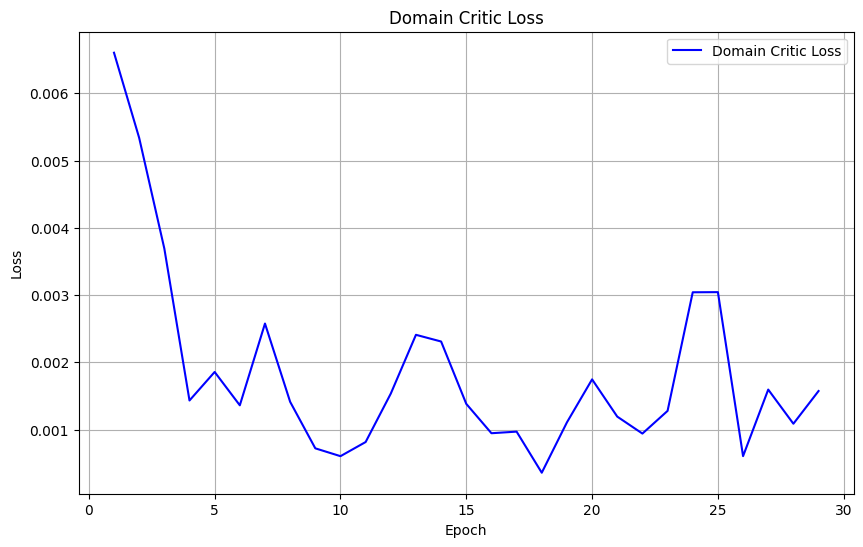

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), losses, 'b-', label='Domain Critic Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Domain Critic Loss')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_21544\1727624484.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_hat_tensor = torch.tensor(x_hat, dtype=torch.float32)


0.22723348
0.025724573


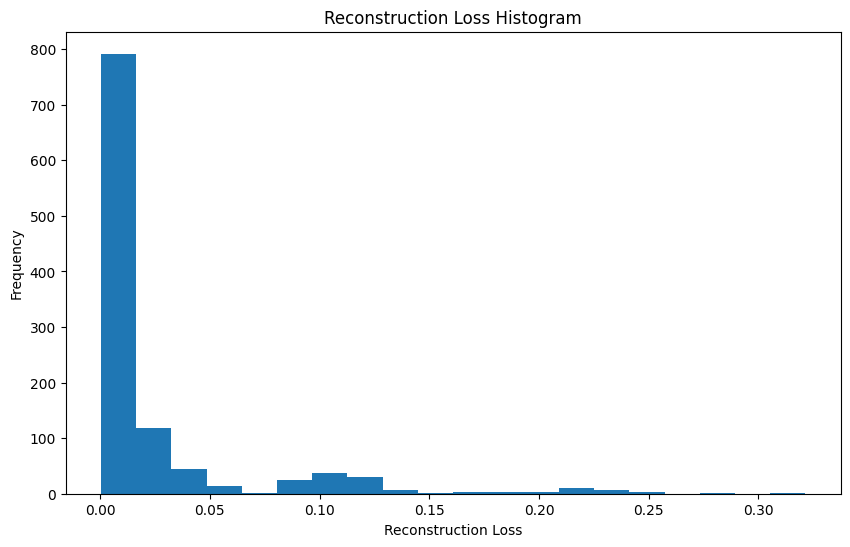

In [128]:
# Convert xt_hat to a PyTorch tensor
x_hat_tensor = torch.tensor(x_hat, dtype=torch.float32)

xt_hat_tensor = torch.tensor(xt_hat, dtype=torch.float32)
reconstruction_loss = model.reconstruction_loss(xt_hat_tensor[yt == 1])
print(np.mean(reconstruction_loss))

# Filter the tensor based on yt
reconstruction_loss = model.reconstruction_loss(x_hat_tensor)
print(np.mean(reconstruction_loss))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=20)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Reconstruction Loss Histogram')
plt.show()

In [129]:
checkpoint = {
    'state_dict': model.state_dict(),
    'device': model.device,
}
index = None

with open("ae_models.txt", "r") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        words = line[:-1].split("/")
        if words[1] == str(input_dim) and words[2] == str(encoder_hidden_dims) and words[3] == str(decoder_hidden_dims):
            index = i
            break
if index is None:
    with open("ae_models.txt", "r") as f:
        index = len(f.readlines())
    with open("ae_models.txt", "a") as f:
        f.write(f"{index}/{input_dim}/{encoder_hidden_dims}/{decoder_hidden_dims}\n")
# Save the checkpoint
torch.save(checkpoint, f"ae_{index}.pth")
print("Model saved successfully!")

Model saved successfully!
